# Spiking neural model implementation of ring-attractor

Implementation based on https://web.stanford.edu/group/brainsinsilicon/documents/lab1_WorkingMemory_000.pdf
Also on https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/spatial-working-memory.html and code from https://github.com/EPFL-LCN/neuronaldynamics-exercises/blob/master/neurodynex/working_memory_network/wm_model.py


In [44]:
from brian2 import *
from brian2tools import *

In [84]:
# Constants
# Exciatatory pyramidal cells
# Inhibitory non pyramidal cells
N_I = 512 # Number of inhibitory neurons
Cm_i = 0.5*nF
gl_i = 25*nS
El_i = -70*mV
g_ext_3 = 3.1*nS
g_ext_i = 2.38*nS
Vth_i = -50*mV
Vreset_i = -60*mV
tref_i = 2*ms
E_ampa = 0*mV
Gii = 0.8*nS
E_gaba = -70*mV
t_ampa = 2*ms
t_gaba = 10*ms

# State variables: count of how many channels are open: s_ext, s_ampa, s_gaba

fext = 1.8*kHz
fext = 10*Hz


# Equations
eqs_i = '''
dv/dt = (-gl_i * (v - El_i) - g_ext_i * s_ext * (v - E_ampa) - \
Gii * s_gaba * (v - E_gaba)) / Cm_i : volt (unless refractory)
ds_ext/dt  = -s_ext/t_ampa          : 1
ds_gaba/dt = -s_gaba/t_gaba         : 1
'''

"""
        s_NMDA_total : 1  # the post synaptic sum of s. compare with s_NMDA_presyn
gl_i    G_leak_inhib
El_i    E_leak_inhib
g_ext_i G_extern2inhib
        s_AMPA
E_ampa  E_AMPA
Gii     G_inhib2inhib
s_gaba  s_GABA
E_gaba  E_GABA
        G_excit2inhib
        s_NMDA_total
        E_NMDA
Cm_i    Cm_inhib
t_ampa  tau_AMPA
s_gaba  s_GABA
t_gaba  tau_GABA

Vth_i   v_firing_threshold_inhib
Vreset_i v_reset_inhib
tref_i  t_abs_refract_inhib
    """

eqs_i = '''
dv/dt = (-gl_i * (v - El_i) - g_ext_i * s_ampa_ext * (v - E_ampa) - \
Gii * s_gaba * (v - E_gaba)) / Cm_i  : volt (unless refractory)
ds_ampa_ext/dt  = -s_ampa_ext/t_ampa : 1
ds_gaba/dt      = -s_gaba/t_gaba     : 1
'''

In [85]:
Pi = NeuronGroup(N_I, eqs_i, threshold = 'v>Vth_i', reset='v=Vreset_i', refractory='tref_i')

In [86]:
PGi = PoissonGroup(N_I, fext)

In [87]:
Cpi = Synapses(PGi, Pi, on_pre='s_ampa_ext+=1')
Cpi.connect(p=1.0)
Cii = Synapses(Pi, target=Pi, on_pre='s_gaba+=1', delay=0.0*ms)
Cii.connect(condition="i!=j", p=1.0)

In [88]:
s_mon = SpikeMonitor(Pi)

In [89]:
run(1*second)

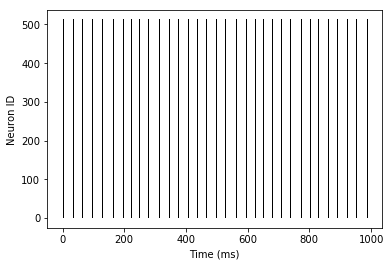

In [90]:
plot(s_mon.t/ms, s_mon.i, ',k')
xlabel('Time (ms)')
ylabel('Neuron ID')
show()

In [ ]:
    """
    Args:
        N_excitatory (int): Size of the excitatory population
        N_inhibitory (int): Size of the inhibitory population
        weight_scaling_factor (float): weight prefactor. When increasing the size of the populations,
            the synaptic weights have to be decreased. Using the default values, we have
            N_excitatory*weight_scaling_factor = 2048 and N_inhibitory*weight_scaling_factor=512
        N_extern_poisson (int): Size of the external input population (Poisson input)
        poisson_firing_rate (Quantity): Firing rate of the external population
        sigma_weight_profile (float): standard deviation of the gaussian input profile in
            the excitatory population.
        Jpos_excit2excit (float): Strength of the recurrent input within the excitatory population.
            Jneg_excit2excit is computed from sigma_weight_profile, Jpos_excit2excit and the normalization
            condition.
        stimulus_center_deg (float): Center of the stimulus in [0, 360]
        stimulus_width_deg (float): width of the stimulus. All neurons in
            stimulus_center_deg +\- (stimulus_width_deg/2) receive the same input current
        stimulus_strength (Quantity): Input current to the neurons at stimulus_center_deg +\- (stimulus_width_deg/2)
        t_stimulus_start (Quantity): time when the input stimulus is turned on
        t_stimulus_duration (Quantity): duration of the stimulus.
        distractor_center_deg (float): Center of the distractor in [0, 360]
        distractor_width_deg (float): width of the distractor. All neurons in
            distractor_center_deg +\- (distractor_width_deg/2) receive the same input current
            distractor_strength (Quantity): Input current to the neurons at
            distractor_center_deg +\- (distractor_width_deg/2)
        t_distractor_start (Quantity): time when the distractor is turned on
        t_distractor_duration (Quantity): duration of the distractor.
        G_inhib2inhib (Quantity): projections from inhibitory to inhibitory population (later
            rescaled by weight_scaling_factor)
        G_inhib2excit (Quantity): projections from inhibitory to excitatory population (later
            rescaled by weight_scaling_factor)
        G_excit2excit (Quantity): projections from excitatory to excitatory population (later
            rescaled by weight_scaling_factor)
        G_excit2inhib (Quantity): projections from excitatory to inhibitory population (later
            rescaled by weight_scaling_factor)
        monitored_subset_size (int): nr of neurons for which a Spike- and Voltage monitor
            is registered.
        sim_time (Quantity): simulation time
"""
N_excitatory=1024
N_inhibitory=256
N_extern_poisson=1000
poisson_firing_rate=1.4 * Hz
weight_scaling_factor=2.
sigma_weight_profile=20.
Jpos_excit2excit=1.6
stimulus_center_deg=180
stimulus_width_deg=40
stimulus_strength=0.07 * namp,
t_stimulus_start=0 * ms
t_stimulus_duration=0 * ms
distractor_center_deg=90
distractor_width_deg=40
distractor_strength=0.0 * namp
t_distractor_start=0 * ms
t_distractor_duration=0 * ms
G_inhib2inhib=.35 * 1.024 * nS
G_inhib2excit=.35 * 1.336 * nS
G_excit2excit=.35 * 0.381 * nS
G_excit2inhib=.35 * 1.2 * 0.292 * nS
monitored_subset_size=1024
sim_time=800. * ms

# specify the excitatory pyramidal cells:
Cm_excit = 0.5 * b2.nF  # membrane capacitance of excitatory neurons
G_leak_excit = 25.0 * b2.nS  # leak conductance
E_leak_excit = -70.0 * b2.mV  # reversal potential
v_firing_threshold_excit = -50.0 * b2.mV  # spike condition
v_reset_excit = -60.0 * b2.mV  # reset voltage after spike
t_abs_refract_excit = 2.0 * b2.ms  # absolute refractory period

    # specify the inhibitory interneurons:
Cm_inhib = 0.2 * b2.nF
G_leak_inhib = 20.0 * b2.nS
E_leak_inhib = -70.0 * b2.mV
v_firing_threshold_inhib = -50.0 * b2.mV
v_reset_inhib = -60.0 * b2.mV
t_abs_refract_inhib = 1.0 * b2.ms

# specify the AMPA synapses
E_AMPA = 0.0 * b2.mV
tau_AMPA = .9 * 2.0 * b2.ms

# specify the GABA synapses
E_GABA = -70.0 * b2.mV
tau_GABA = 10.0 * b2.ms

# specify the NMDA synapses
E_NMDA = 0.0 * b2.mV
tau_NMDA_s = .65 * 100.0 * b2.ms  # orig: 100
tau_NMDA_x = .94 * 2.0 * b2.ms
alpha_NMDA = 0.5 * b2.kHz

    # projections from the external population
G_extern2inhib = 2.38 * b2.nS
G_extern2excit = 3.1 * b2.nS

# projectsions from the inhibitory populations
G_inhib2inhib *= weight_scaling_factor
G_inhib2excit *= weight_scaling_factor

# projections from the excitatory population
G_excit2excit *= weight_scaling_factor
G_excit2inhib *= weight_scaling_factor  # todo: verify this scaling

t_stimulus_end = t_stimulus_start + t_stimulus_duration
t_distractor_end = t_distractor_start + t_distractor_duration
# compute the stimulus index
stim_center_idx = int(round(N_excitatory / 360. * stimulus_center_deg))
stim_width_idx = int(round(N_excitatory / 360. * stimulus_width_deg / 2))
stim_target_idx = [idx % N_excitatory
                   for idx in range(stim_center_idx - stim_width_idx, stim_center_idx + stim_width_idx + 1)]
# compute the distractor index
distr_center_idx = int(round(N_excitatory / 360. * distractor_center_deg))
distr_width_idx = int(round(N_excitatory / 360. * distractor_width_deg / 2))
distr_target_idx = [idx % N_excitatory for idx in range(distr_center_idx - distr_width_idx,
                                                        distr_center_idx + distr_width_idx + 1)]

# precompute the weight profile for the recurrent population
tmp = math.sqrt(2. * math.pi) * sigma_weight_profile * erf(180. / math.sqrt(2.) / sigma_weight_profile) / 360.
Jneg_excit2excit = (1. - Jpos_excit2excit * tmp) / (1. - tmp)
presyn_weight_kernel = \
    [(Jneg_excit2excit +
      (Jpos_excit2excit - Jneg_excit2excit) *
      math.exp(-.5 * (360. * min(j, N_excitatory - j) / N_excitatory) ** 2 / sigma_weight_profile ** 2))
     for j in range(N_excitatory)]
# validate the normalization condition: (360./N_excitatory)*sum(presyn_weight_kernel)/360.
fft_presyn_weight_kernel = rfft(presyn_weight_kernel)
weight_profile_45 = deque(presyn_weight_kernel)
rot_dist = int(round(len(weight_profile_45) / 8))
weight_profile_45.rotate(rot_dist)

# define the inhibitory population
inhib_lif_dynamics = """
    s_NMDA_total : 1  # the post synaptic sum of s. compare with s_NMDA_presyn
    dv/dt = (
    - G_leak_inhib * (v-E_leak_inhib)
    - G_extern2inhib * s_AMPA * (v-E_AMPA)
    - G_inhib2inhib * s_GABA * (v-E_GABA)
    - G_excit2inhib * s_NMDA_total * (v-E_NMDA)/(1.0+1.0*exp(-0.062*v/volt)/3.57)
    )/Cm_inhib : volt (unless refractory)
    ds_AMPA/dt = -s_AMPA/tau_AMPA : 1
    ds_GABA/dt = -s_GABA/tau_GABA : 1
"""

    inhib_pop = NeuronGroup(
    N_inhibitory, model=inhib_lif_dynamics,
    threshold="v>v_firing_threshold_inhib", reset="v=v_reset_inhib", refractory=t_abs_refract_inhib,
    method="rk2")
# initialize with random voltages:
inhib_pop.v = numpy.random.uniform(v_reset_inhib / b2.mV, high=v_firing_threshold_inhib / b2.mV,
                                   size=N_inhibitory) * b2.mV
# set the connections: inhib2inhib
syn_inhib2inhib = Synapses(inhib_pop, target=inhib_pop, on_pre="s_GABA += 1.0", delay=0.0 * b2.ms)
syn_inhib2inhib.connect(condition="i!=j", p=1.0)
# set the connections: extern2inhib
input_ext2inhib = PoissonInput(target=inhib_pop, target_var="s_AMPA",
                               N=N_extern_poisson, rate=poisson_firing_rate, weight=1.0)

# specify the excitatory population:
excit_lif_dynamics = """
    I_stim : amp
    s_NMDA_total : 1  # the post synaptic sum of s. compare with s_NMDA_presyn
    dv/dt = (
    - G_leak_excit * (v-E_leak_excit)
    - G_extern2excit * s_AMPA * (v-E_AMPA)
    - G_inhib2excit * s_GABA * (v-E_GABA)
    - G_excit2excit * s_NMDA_total * (v-E_NMDA)/(1.0+1.0*exp(-0.062*v/volt)/3.57)
    + I_stim
    )/Cm_excit : volt (unless refractory)
    ds_AMPA/dt = -s_AMPA/tau_AMPA : 1
    ds_GABA/dt = -s_GABA/tau_GABA : 1
    ds_NMDA/dt = -s_NMDA/tau_NMDA_s + alpha_NMDA * x * (1-s_NMDA) : 1
    dx/dt = -x/tau_NMDA_x : 1
"""

excit_pop = NeuronGroup(N_excitatory, model=excit_lif_dynamics,
                        threshold="v>v_firing_threshold_excit", reset="v=v_reset_excit; x+=1.0",
                        refractory=t_abs_refract_excit, method="rk2")
# initialize with random voltages:
excit_pop.v = numpy.random.uniform(v_reset_excit / b2.mV, high=v_firing_threshold_excit / b2.mV,
                                   size=N_excitatory) * b2.mV
excit_pop.I_stim = 0. * b2.namp
# set the connections: extern2excit
input_ext2excit = PoissonInput(target=excit_pop, target_var="s_AMPA",
                               N=N_extern_poisson, rate=poisson_firing_rate, weight=1.0)

# set the connections: inhibitory to excitatory
syn_inhib2excit = Synapses(inhib_pop, target=excit_pop, on_pre="s_GABA += 1.0")
syn_inhib2excit.connect(p=1.0)

# set the connections: excitatory to inhibitory NMDA connections
syn_excit2inhib = Synapses(excit_pop, inhib_pop,
                           model="s_NMDA_total_post = s_NMDA_pre : 1 (summed)", method="rk2")
syn_excit2inhib.connect(p=1.0)



        
        